https://medium.com/analytics-vidhya/bio-tagged-text-to-original-text-99b05da6664

https://www.programcreek.com/python/?CodeExample=read+conll

https://applied-language-technology.mooc.fi/html/notebooks/part_iii/06_text_linguistics.html#interacting-with-conll-u-annotations-in-python

https://www.nltk.org/api/nltk.tag.html


https://stackoverflow.com/questions/58736548/how-to-use-word-embedding-as-features-for-crf-sklearn-crfsuite-model-training

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import conllu
import pyconll 
import spacy
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger') #for pos_tags


C:\Users\KYRIAKOS ARISTIDOU\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KYRIAKOS
[nltk_data]     ARISTIDOU\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
def read_and_pos(filename):
  words,biotags = [],[]
  result = []
  with open(filename,encoding="utf8") as file:
    for line in file:
      w = line.strip().split('\t')
      if len(w) > 1:
        words.append(w[0])
        biotags.append(w[1])
      else:
        pos_tags = [pos for token, pos in pos_tag(words)]
        finaltags = [(token, pos, tg) for token, pos, tg in zip(words, pos_tags, biotags)]
        result.append(finaltags)
        words,biotags,pos_tags,finaltags = [],[],[],[]
        continue

  return result 

 


In [4]:
train = read_and_pos('wnut17train.conll')
test = read_and_pos('emerging.test.annotated')
dev = read_and_pos('emerging.dev.conll')

In [33]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        # 'wordlength': len(word),                                      #newfeature
        # 'wordmixedcap': len([x for x in word[1:] if x.isupper()])>0,  #newfeature
        # 'wordallcap': len([x for x in word if x.isupper()])==len(word), #newfeature
        'postag': postag,
        'postag[:2]': postag[:2],
        # 'distfromsentbegin': i         #newfeature
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            # '-1:wordlength': len(word1),
            # '-1:wordmixedcap': len([x for x in word1[1:] if x.isupper()])>0, 
            # '-1:wordallcap': len([x for x in word if x.isupper()])==len(word),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            # '+1:wordlength': len(word1),
            # '+1:wordmixedcap': len([x for x in word1[1:] if x.isupper()])>0,
            # '+1:wordallcap': len([x for x in word if x.isupper()])==len(word),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [29]:
%%time
X_train = [sent2features(s) for s in train]
y_train = [sent2labels(s) for s in train]

X_dev = [sent2features(s) for s in dev]
y_dev = [sent2labels(s) for s in dev]

X_test = [sent2features(s) for s in test]
y_test = [sent2labels(s) for s in test]

CPU times: total: 672 ms
Wall time: 949 ms


In [30]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: total: 19 s
Wall time: 25.4 s


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [31]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-location',
 'I-location',
 'B-group',
 'B-corporation',
 'B-person',
 'B-creative-work',
 'B-product',
 'I-person',
 'I-creative-work',
 'I-corporation',
 'I-group',
 'I-product']

In [32]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.14220916330790342

In [11]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

                 precision    recall  f1-score   support

  B-corporation      0.000     0.000     0.000        66
  I-corporation      0.000     0.000     0.000        22
B-creative-work      0.333     0.035     0.064       142
I-creative-work      0.296     0.037     0.065       218
        B-group      0.300     0.036     0.065       165
        I-group      0.357     0.071     0.119        70
     B-location      0.385     0.233     0.290       150
     I-location      0.231     0.064     0.100        94
       B-person      0.551     0.138     0.220       429
       I-person      0.547     0.221     0.315       131
      B-product      0.600     0.024     0.045       127
      I-product      0.375     0.048     0.085       126

      micro avg      0.430     0.093     0.153      1740
      macro avg      0.331     0.076     0.114      1740
   weighted avg      0.401     0.093     0.142      1740



Hyperparameter Optimization


In [30]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True,
    epsilon  = 1e-5
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 18.7min finished


CPU times: total: 1min 40s
Wall time: 19min 18s


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=1e-05, error_sensitive=None,
                                 gamma=None, keep...
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000283060E47F0>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(flat_f1_score, aver

In [24]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.0035238036113941795, 'c2': 0.048096808893646446}
best CV score: 0.39083848563387774
model size: 1.76M


Dark blue => 0.3, dark red => 0.3908


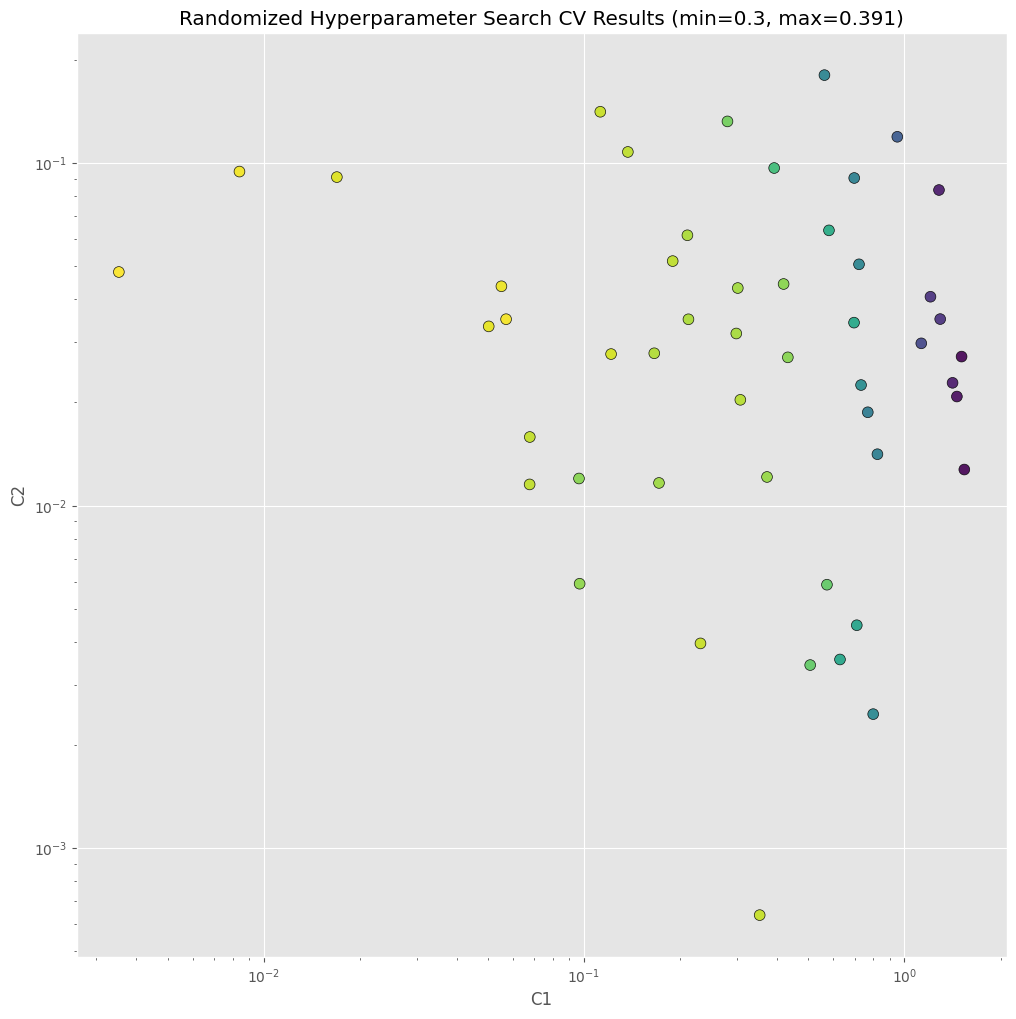

In [25]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [26]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

                 precision    recall  f1-score   support

  B-corporation      0.995     0.986     0.991       221
  I-corporation      0.978     0.978     0.978        46
B-creative-work      0.972     0.986     0.979       140
I-creative-work      0.981     0.995     0.988       206
        B-group      0.989     0.996     0.992       264
        I-group      0.993     0.993     0.993       150
     B-location      0.995     0.991     0.993       548
     I-location      1.000     0.988     0.994       245
       B-person      0.998     0.994     0.996       660
       I-person      1.000     0.997     0.999       335
      B-product      1.000     0.979     0.989       142
      I-product      0.995     1.000     0.998       203

      micro avg      0.994     0.992     0.993      3160
      macro avg      0.991     0.990     0.991      3160
   weighted avg      0.994     0.992     0.993      3160



In [27]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-person -> I-person 4.455447
B-product -> I-product 4.187016
I-creative-work -> I-creative-work 4.178472
B-creative-work -> I-creative-work 4.090103
B-group -> I-group 3.875313
I-corporation -> I-corporation 3.864654
I-product -> I-product 3.788509
B-corporation -> I-corporation 3.705953
I-group -> I-group 3.656703
B-location -> I-location 3.161597
I-location -> I-location 2.993892
O      -> O       2.526975
I-person -> I-person 2.099321
O      -> B-person 1.178896
B-group -> B-creative-work 0.661581
O      -> B-group 0.659952
O      -> B-corporation 0.650525
I-corporation -> B-location 0.516680
O      -> B-creative-work 0.460910
O      -> B-location 0.405230

Top unlikely transitions:
I-person -> I-location -1.689823
I-creative-work -> I-location -1.701712
B-location -> I-product -1.711747
I-person -> I-group -1.713531
B-corporation -> I-location -1.721678
B-group -> I-person -1.722760
B-creative-work -> O       -1.839827
I-group -> B-group -1.912401
B-creativ

In [28]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
9.085842 B-corporation word.lower():twitter
5.972357 B-person word.lower():pope
5.433715 B-location word.lower():jupiter
5.243101 B-corporation word.lower():facebook
4.971460 B-location word.lower():perth
4.969353 B-corporation word.lower():walmart
4.968509 B-product word.lower():iphone
4.824429 B-location word.lower():bahamas
4.791312 B-person word.lower():4dbling
4.595813 B-location word.lower():peppers
4.174694 B-location word.lower():inverness
4.174694 B-location -1:word.lower():tae
4.040333 B-location word.lower():lancashire
4.034915 B-location word.lower():#denver
4.008178 B-group  -1:word.lower():vs
3.999690 B-person word.lower():beyonce
3.983076 B-person word.lower():billy
3.876017 B-person word.lower():ellwood
3.850899 B-person word.lower():taylor
3.808141 B-person -1:word.lower():silly
3.754907 B-group  +1:word.lower():vs
3.735351 B-person word.lower():justin
3.731052 B-group  word.lower():phily
3.682345 B-corporation word.lower():snapchat
3.589802 B-location wo